In [1]:
# Load libraries
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.exceptions import UndefinedMetricWarning
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn import datasets
from sklearn.model_selection import RepeatedKFold, GridSearchCV
from sklearn import svm
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report, precision_score, f1_score,
    precision_recall_curve, average_precision_score,
    roc_auc_score, roc_curve, auc, ConfusionMatrixDisplay, RocCurveDisplay
   )

import xgboost as xgb
from xgboost import XGBClassifier

import tensorflow as tf

from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.metrics import AUC

import warnings

import holoviews as hv

from datetime import datetime

from xgboost import XGBRFClassifier

import os

from sklearn.neural_network import MLPClassifier

import pickle

In [15]:
df=pd.read_csv('/content/lending-club-loan_ML.csv', low_memory=False)

In [10]:
def save_score(true, pred, model_name, train=True, auc_roc=None):
    timestamp = datetime.now().strftime('%Y%m')
    file_name = f"{model_name}_TestResults_{timestamp}.csv"

    clf_report = classification_report(true, pred, output_dict=True)
    accuracy = accuracy_score(true, pred) * 100
    roc_auc = roc_auc_score(true, pred) * 100
    confusion = confusion_matrix(true, pred)

    if auc_roc is not None:
        result_df = pd.DataFrame({
            'Set': ['Train' if train else 'Test'],
            'Accuracy': [accuracy],
            'AUC-ROC': [roc_auc],
            'Classification Report': [clf_report],
            'Confusion Matrix': [confusion.tolist()]
        })
    else:
        result_df = pd.DataFrame({
            'Set': ['Train' if train else 'Test'],
            'Accuracy': [accuracy],
            'AUC-ROC': [roc_auc],
            'Classification Report': [clf_report],
            'Confusion Matrix': [confusion.tolist()]
        })

    current_dir = os.getcwd()
    pruebas_dir = os.path.join(current_dir, 'Pruebas')
    os.makedirs(pruebas_dir, exist_ok=True)

    # Unir la ruta del directorio 'pruebas' con el nombre del archivo CSV
    file_path = os.path.join(pruebas_dir, file_name)

    result_df.to_csv(file_path, index=False)

In [11]:
def print_score(true, pred, train=True):
    if train:
        clf_report = pd.DataFrame(classification_report(true, pred, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(true, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(true, pred)}\n")

        # Guardar resultados en un archivo CSV
        save_score(true, pred, model_name, train=True)

    elif train==False:
        clf_report = pd.DataFrame(classification_report(true, pred, output_dict=True))
        print("Test Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(true, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(true, pred)}\n")

        # Guardar resultados en un archivo CSV
        save_score(true, pred, model_name, train=False)

In [12]:
def plot_confusion_matrix(model, X_test, y_test, model_name):
    # Predicciones del modelo
    preds = model.predict(X_test)

    # Matriz de confusión
    cm = confusion_matrix(y_test, preds)
    tn, fp, fn, tp = cm.ravel()

    # Calcular porcentajes
    total_correct = tp + tn
    total_errors = fp + fn
    percent_correct = total_correct / (tp + tn + fp + fn) * 100
    percent_errors = total_errors / (tp + tn + fp + fn) * 100

    # Configurar el gráfico
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=['Pred Neg', 'Pred Pos'], yticklabels=['True Neg', 'True Pos'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()

    # Imprimir resultados
    print(f"\nResults for {model_name}:")
    print(f"Total Correct: {total_correct} ({percent_correct:.2f}%)")
    print("--" * 30)
    print(f"True Positives (TP): {tp} ({tp / (tp + fn) * 100:.2f}%)")
    print(f"True Negatives (TN): {tn} ({tn / (tn + fp) * 100:.2f}%)")
    print("\nTotal Errors:")
    print(f"False Positives (FP): {fp} ({fp / (tn + fp) * 100:.2f}%)")
    print(f"False Negatives (FN): {fn} ({fn / (tp + fn) * 100:.2f}%)")

In [13]:
def plot_roc_pr_curves(model, X_test, y_test, model_name):
    # Curva ROC
    y_test_probs = model.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_test_probs)
    roc_auc = roc_auc_score(y_test, y_test_probs)

    # Curva P-R
    precision, recall, _ = precision_recall_curve(y_test, y_test_probs)

    # Crear la figura con dos subgráficos
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    # Graficar Curva ROC
    ax1.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (AUC = {roc_auc:.2f})')
    ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guessing')
    ax1.set_xlim([0.0, 1.0])
    ax1.set_ylim([0.0, 1.05])
    ax1.set_xlabel('Tasa de Falsos Positivos')
    ax1.set_ylabel('Tasa de Verdaderos Positivos')
    ax1.set_title(f'Curva ROC - {model_name}')
    ax1.legend(loc='lower right')

    # Graficar Curva P-R
    ax2.plot(recall, precision, color='darkorange', lw=2, label='P-R curve')
    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')
    ax2.set_title('Precision-Recall Curve')
    ax2.legend()

    plt.tight_layout()
    plt.show()

In [19]:
# Creacion del modelo - LOGISTIC REGRESION
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

model_name = 'LogisticRegression'

target = 'loan_status'
X = df.drop(columns=[target])
y = df[target]

# División de datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Instanciamos el PCA y el pipeline para Regresión Logística
pca = PCA(n_components=0.95)  # Elige el número de componentes que explica al menos el 95% de la varianza
reg_log = Pipeline(steps=[
    ('imputer', KNNImputer()),
    ('scaler', StandardScaler()),
    ('pca', pca),
    ('reglog', LogisticRegression(max_iter=1000, solver='liblinear'))
])

# Parámetros de modelo 1
reg_log_params = {
    'reglog__penalty': ['l1', 'l2'],
    'reglog__C': np.logspace(0, 4, 10)
}

# Grid search con modelo 1
gs_reg_log = GridSearchCV(reg_log, reg_log_params, cv=10, scoring='accuracy', verbose=1, n_jobs=-1)

# Entrenamos el grid search
gs_reg_log.fit(X_train, y_train)

# Resultados del grid search para Regresión Logística
print(f'Resultados del modelo {model_name}:')
print(f'Precisión en el conjunto de entrenamiento: {gs_reg_log.best_score_:.4f}')
print(f'Mejores parámetros: {gs_reg_log.best_params_}')

# Precisión y recall en el conjunto de prueba
preds_reg_log = gs_reg_log.best_estimator_.predict(X_test)
accuracy = accuracy_score(y_test, preds_reg_log)
recall = recall_score(y_test, preds_reg_log)

print(f'Precisión en el conjunto de prueba: {accuracy:.4f}')
print(f'Recall en el conjunto de prueba: {recall:.4f}')

Fitting 10 folds for each of 20 candidates, totalling 200 fits
Resultados del modelo LogisticRegression:
Precisión en el conjunto de entrenamiento: 0.8899
Mejores parámetros: {'reglog__C': 166.81005372000593, 'reglog__penalty': 'l2'}
Precisión en el conjunto de prueba: 0.8862
Recall en el conjunto de prueba: 0.9918


Train Result:
Accuracy Score: 89.00%
_______________________________________________
CLASSIFICATION REPORT:
                      0              1  accuracy      macro avg   weighted avg
precision      0.941150       0.884547  0.890047       0.912848       0.895623
recall         0.467336       0.992890  0.890047       0.730113       0.890047
f1-score       0.624548       0.935592  0.890047       0.780070       0.874725
support    26589.000000  109287.000000  0.890047  135876.000000  135876.000000
_______________________________________________
Confusion Matrix: 
 [[ 12426  14163]
 [   777 108510]]

Test Result:
Accuracy Score: 88.62%
_______________________________________________
CLASSIFICATION REPORT:
                     0             1  accuracy     macro avg  weighted avg
precision     0.930864      0.881545  0.886249      0.906205      0.891209
recall        0.453125      0.991799  0.886249      0.722462      0.886249
f1-score      0.609539      0.933428  0.886249      0.771483 

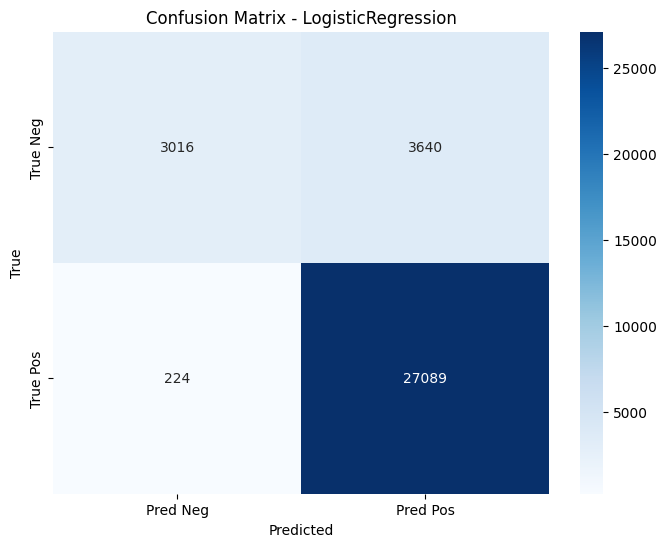


Results for LogisticRegression:
Total Correct: 30105 (88.62%)
------------------------------------------------------------
True Positives (TP): 27089 (99.18%)
True Negatives (TN): 3016 (45.31%)

Total Errors:
False Positives (FP): 3640 (54.69%)
False Negatives (FN): 224 (0.82%)


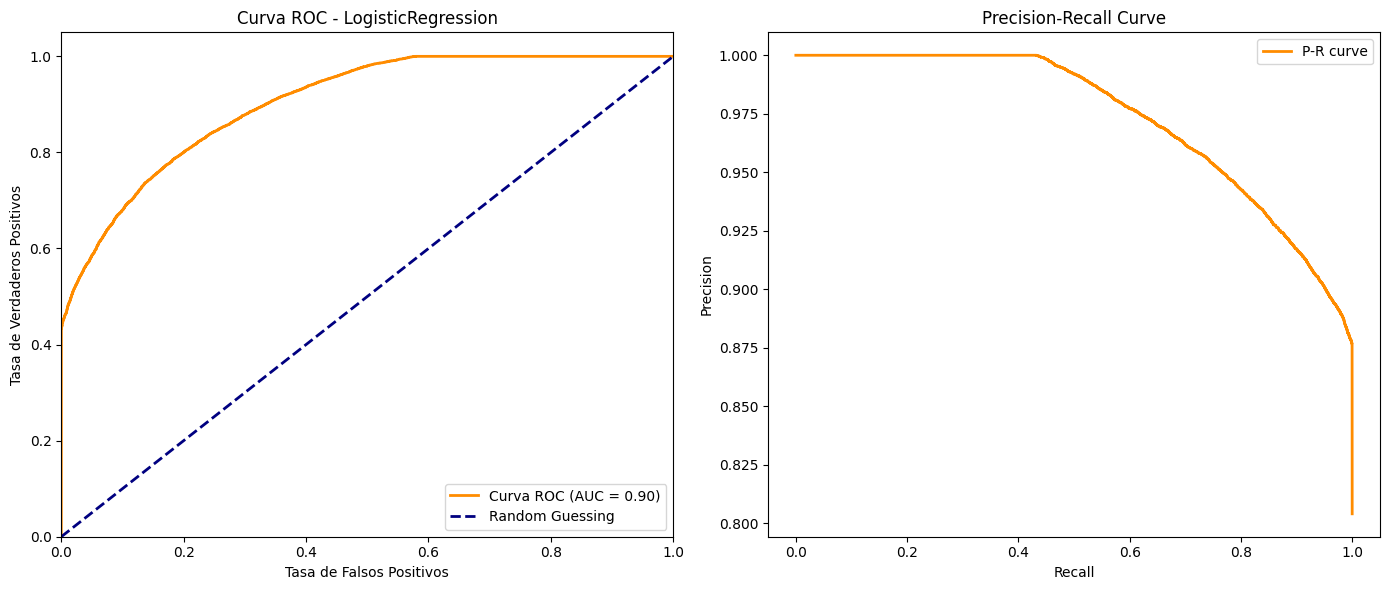

In [20]:
# Predicciones en los conjuntos de entrenamiento y prueba con los mejores parámetros
train_preds_reg_log= gs_reg_log.best_estimator_.predict(X_train)
test_preds_reg_log= gs_reg_log.best_estimator_.predict(X_test)

model_name='LogisticRegression'
# Llamada a las funciones después de entrenar el modelo
print_score(y_train, train_preds_reg_log, train=True)
print_score(y_test, test_preds_reg_log, train=False)
plot_confusion_matrix(gs_reg_log.best_estimator_, X_test, y_test, model_name)
plot_roc_pr_curves(gs_reg_log.best_estimator_, X_test, y_test, model_name)

save_score(y_train, train_preds_reg_log, model_name, train=True)
save_score(y_test, test_preds_reg_log, model_name, train=False)

In [ ]:
# Guardar el modelo
import pickle

with open('finished_model.model_LGS RGR', "wb") as archivo_salida:
    pickle.dump(models_gridsearch['LGS RGR'].best_estimator_, archivo_salida)